<h1 style="text-align:center;">News Article Recommendation System</h1>
<h1 style="text-align:center;">Content Based and Collaboration Based (From Scratch) </h1>

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [203]:
## Importing the data set
consumer_transactions = pd.read_csv('consumer_transanctions.csv')
platform_content = pd.read_csv('platform_content.csv')

C:\Users\Dell\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [204]:
consumer_transactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [205]:
## Interaction Types
consumer_transactions['interaction_type'].value_counts()

content_watched         61086
content_liked            5745
content_saved            2463
content_commented_on     1611
content_followed         1407
Name: interaction_type, dtype: int64

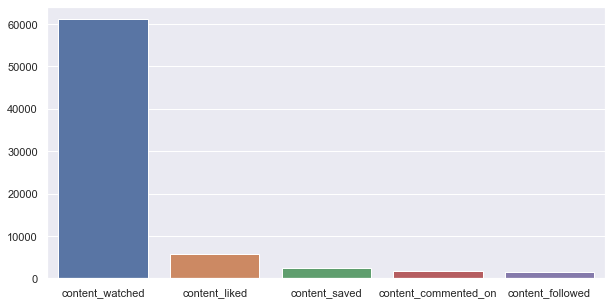

In [206]:
ax = plt.figure(figsize=(10,5))
sns.barplot(x=consumer_transactions['interaction_type'].value_counts().index,y=consumer_transactions['interaction_type'].value_counts().values)

### Content Watched, Liked, Saved, Commented on or Followed - all suggest an interest in the topic of the article. Hence all these interactions can be kept for the system to use while suggesting recommendations

In [207]:
#platform_content.head()

In [208]:
consumer_transactions.isnull().any()

event_timestamp         False
interaction_type        False
item_id                 False
consumer_id             False
consumer_session_id     False
consumer_device_info     True
consumer_location        True
country                  True
dtype: bool

In [209]:
platform_content.isnull().any()

event_timestamp         False
interaction_type        False
item_id                 False
producer_id             False
producer_session_id     False
producer_device_info     True
producer_location        True
producer_country         True
item_type               False
item_url                False
title                   False
text_description        False
language                False
dtype: bool

### Creating a common dataset

In [210]:
#platform_content['item_id'].nunique()

In [211]:
content_info= platform_content.groupby('item_id').agg({"title":"first","text_description":"first","language":"first"})

In [212]:
#len(content_info)

In [213]:
user_item = consumer_transactions.groupby(['consumer_id','item_id'],as_index=False).agg({"interaction_type":'first',"country":"first"})

In [214]:
#user_item.head()

In [215]:
#len(user_item) #40710

In [216]:
user_item = user_item.merge(right=content_info,on='item_id',how='left')

In [217]:
#user_item.head()

In [218]:
user_item.isnull().any()

consumer_id         False
item_id             False
interaction_type    False
country              True
title               False
text_description    False
language            False
dtype: bool

### Types of languages

In [219]:
user_item.language.value_counts()

en    26206
pt    14449
la       26
ja       23
es        6
Name: language, dtype: int64

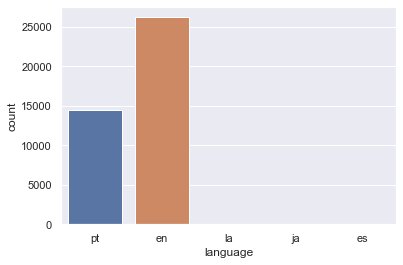

In [220]:
sns.countplot(x=user_item.language)

In [221]:
# keeping articles of language English and Portugese only as the rest are just 0.25% of the whole dataset
user_item = user_item[user_item['language'].isin(['en','pt'])]

### Considering only those articles which were interacted with atleast 5 times

In [222]:
user_item['counter'] = 1

In [223]:
user_item_copy = user_item.copy(deep=True)

In [224]:
item_counter = user_item_copy.groupby(['item_id']).agg({"counter":sum}).reset_index()

In [225]:
items_consumed_atleast_five_users = list(item_counter[item_counter['counter']>=5]['item_id'].unique())

In [226]:
user_item = user_item[user_item['item_id'].isin(items_consumed_atleast_five_users)]

In [227]:
user_item.drop('counter',inplace=True,axis=1)

### Stratified Trait Test Split of Data

In [228]:
user_item_train, user_item_test  = train_test_split(user_item,train_size=0.75, random_state=42,stratify=user_item['language'])

In [229]:
user_item_verify = user_item.copy(deep=True)
user_item_verify_train = user_item_train.copy(deep=True)
user_item_verify_test = user_item_test.copy(deep=True)

In [230]:
# country will not have much weightage in the article to recommend as would the content of the article
# language too will not be explicitly needed. The content of the article read will itself help in identifying the language
# title too is not needed seperately as the text description will entail the title in its content
# interaction_type are all positive and hence they need to be seperately marked
user_item.drop(['country','title','language','interaction_type'],inplace=True,axis=1)
user_item_train.drop(['country','title','language','interaction_type'],inplace=True,axis=1)
user_item_test.drop(['country','title','language','interaction_type'],inplace=True,axis=1)

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [231]:
len(user_item_train)

28889

In [232]:
len(user_item_test)

9630

In [233]:
user_item_train.reset_index(inplace=True,drop=True)
user_item_test.reset_index(inplace=True,drop=True)

## Content Based Recommendation - 

We will be using the <b>entire dataset to make a content based recommendation system.</b><br><br>
Splitting the data into train and test does not make sense while making a content based model.
We want all the articles to be in the similarity matrix for them to be in the recommendation list.<br><br>
<b>If we will be excluding some articles while making the similarity matrix, they will never be included in the 
recommendation list</b>

In [234]:
item_df = user_item[['item_id','text_description']].drop_duplicates()

In [235]:
item_df.reset_index(inplace=True)

In [236]:
item_df.drop('index',inplace=True,axis=1)

In [237]:
keywords = item_df['text_description'].tolist()

In [238]:
len(keywords)

2105

### Removing Stop words of both languages - English and Portugal

In [239]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
keywords = [tokenizer.tokenize(keyword.lower()) for keyword in keywords]

In [240]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [241]:
stop_words_en = stopwords.words('english')
stop_words_pte = stopwords.words('portuguese')

In [242]:
stop_words = set(stop_words_en+stop_words_pte)

In [243]:
for words in keywords:
    for word in words:
        if (word in stop_words or word.isnumeric()==True):
            words.remove(word)

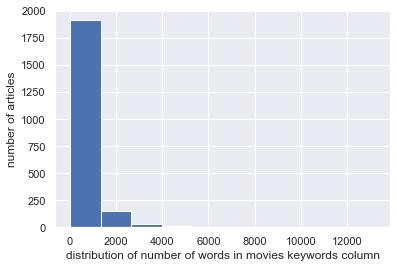

In [244]:
# analysing the number of keywords in the text
number_of_keywords = []
for words in keywords:
    n_keywords = len(words)
    number_of_keywords.append(n_keywords)

plt.hist(number_of_keywords,bins=10,)
plt.xlabel('distribution of number of words in movies keywords column')
plt.ylabel('number of articles')
plt.show()

### Calculating TFIDF using cosine similarity

In [245]:
import gensim

In [246]:
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(keywords) # create a dictionary of words from our keywords

In [247]:
len(dictionary) #71442

59033

In [248]:
corpus = [dictionary.doc2bow(doc) for doc in keywords]

In [249]:
from gensim.models.tfidfmodel import TfidfModel

In [250]:
tfidf = TfidfModel(corpus)

In [251]:
from gensim.similarities import MatrixSimilarity

In [252]:
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))
print(sims)

MatrixSimilarity<2105 docs, 59033 features>


In [253]:
#item_df.head()

In [254]:
platform_content[platform_content['language']=='pt'][['item_id','title']]

,item_id,title
10,-9157338616628196758,Situação financeira ruim de varejistas pressio...
16,-5917314377186856799,Artigos e Palestras - Programa Agricultura de ...
17,6157037646878010131,Rede Agricultura de Precisão II
21,-1672166631728511207,O potencial do bitcoin na América Latina
23,5714314286511882372,Como Startups e Grandes Empresas podem colabor...
...,...,...
3107,-7264217791213422584,Qual é o valor da área de T&D na sua empresa?
3108,-2402288292108892893,Como testar exceções em Java com o JUnit - Cod...
3109,-624901815223005993,"A.I. Duet, crie melodias usando o aprendizado ..."
3111,-8591127493017117985,"IBM e Visa transformam automóveis, eletrodomés..."


In [255]:
## function to remove stop words and tokenise the text
def process_sentence(description):
    tokenised = tokenizer.tokenize(description.lower())
    for word in tokenised:
        if (word in stop_words or word.isnumeric()==True):
            tokenised.remove(word)
            
    return tokenised

In [256]:
## Function to recommend articles based on a given article
def news_recommendation_using_item_id(news_id, number_of_recs=5):
    news = item_df.loc[item_df.item_id==news_id] # get the news article row
    keywords = process_sentence(news['text_description'].values[0]) #get the keywords as a Series
    
    query_doc = keywords # set the query_doc to the list of keywords
    
    query_doc_bow = dictionary.doc2bow(query_doc) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the article ID and it's tf-idf value for the news article

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between the given article and 
    # every other article. 
    #So the length is the number of articles we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=item_df.item_id.values) #Convert to a Series
    top_articles = similarity_series.sort_values(ascending=False)[1:number_of_recs+1] 
    # get the top matching results, i.e. most similar articles; 
    # start from index 1 because every article is the most similar to itself

    #print the words with the highest tf-idf values for the provided article:(title, score)
    sorted_tfidf_weights = sorted(tfidf[corpus[news.index.values.tolist()[0]]], key=lambda w: w[1], reverse=True)
    print('The top 5 words associated with this news article by tf-idf are: ')
    for term_id, weight in sorted_tfidf_weights[:5]:
        print(" '%s' with a tf-idf score of %.3f" %(dictionary.get(term_id), weight))
    
    # Print the top matching articles
    print("Our top %s most similar news articles for the news article '%s' are:" %(number_of_recs, platform_content[platform_content['item_id']==news_id]['title'].values[0]))
    for idx, (article,score) in enumerate(zip(top_articles.index, top_articles)):
        print("%d '%s' with a similarity score of %.3f" %(idx+1, platform_content[platform_content['item_id']==article]['title'].values[0], score))

In [257]:
news_recommendation_using_item_id(6157037646878010131)

The top 5 words associated with this news article by tf-idf are: 
 'agricultura' with a tf-idf score of 0.538
 'embrapa' with a tf-idf score of 0.373
 'precisão' with a tf-idf score of 0.356
 'produção' with a tf-idf score of 0.124
 'agrícola' with a tf-idf score of 0.112
Our top 5 most similar news articles for the news article 'Rede Agricultura de Precisão II' are:
1 'Artigos e Palestras - Programa Agricultura de Precisão do SENAR' with a similarity score of 0.500
2 'Agronegócio entra na era da agricultura digital | Economia, Notícias | Tribuna PR - Paraná Online' with a similarity score of 0.362
3 'Especial Agrishow: Soluções de agricultura de precisão elevam produtividade e aumentam a qualidade do plantio' with a similarity score of 0.360
4 'Heroína, nazistas e agente laranja: por dentro da fusão do ano' with a similarity score of 0.155
5 'Hackathon - Portal Embrapa' with a similarity score of 0.150


In [258]:
# Function to recommend articles using a user
def news_recommendation_using_user_id(user_id):
    
    article_dictionary = {}
    item_ids = user_item[user_item['consumer_id']==user_id]['item_id'].to_list()
    
    for item in item_ids:
        news = item_df.loc[item_df.item_id==item] # get the news article row
        keywords = process_sentence(news['text_description'].values[0]) # get the keywords as a Series 
        
        query_doc = keywords #set the query_doc to the list of keywords
    
        query_doc_bow = dictionary.doc2bow(query_doc) # get a bag of words from the query_doc
        query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
        # of the article ID and it's tf-idf value for the movie

        similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our article and every other article. 
        #So the length is the number of articles we have. To do this, we pass our list of tf-idf tuples to sims.

        similarity_series = pd.Series(similarity_array.tolist(), index=item_df.item_id.values) #Convert to a Series
        top_hits = similarity_series.sort_values(ascending=False)[1:11]
        
        
        for (news_id,score) in zip(top_hits.index,top_hits):
            if news_id in article_dictionary:
                article_dictionary[news_id]+=score
            else:
                article_dictionary[news_id] = score
        
    sorted_items = sorted(article_dictionary.items(), key = 
             lambda kv:(kv[1], kv[0]),reverse=True)
    
    top_10_recommendations = []

        
    for key,value in sorted_items:
        if key not in item_ids and len(top_10_recommendations)<10:
            top_10_recommendations.append((key,value))
        
    output = []
        
    # Print the top matching articles
    for item_id,score in top_10_recommendations:
        
        output.append(platform_content[platform_content['item_id']==item_id]['title'].values[0])
    
    return output

In [259]:
## Articles that were recommended
news_recommendation_using_user_id(-9212075797126931087)

['How to Improve 8 Major Problem Areas for Japanese Learners of All Levels',
 'Código Google: Introdução da próxima geração do Google Tag Manager e do Tag Manager 360 para Mobile Apps',
 'Top 10 GCP sessions from Google I/O 2016',
 'Google I/O 2016: Develop, Grow & Earn',
 "Google's Firebase Team Picks Up Twitter's Fabric",
 'Cookbook',
 'Android Studio 2.0 | Android Developers Blog',
 'Android Studio 2.2',
 'One weird trick that will change the way you code forever: JavaScript TDD',
 'Clean Coder Blog']

In [260]:
## Articles that the user had read
user_item_verify[user_item_verify['consumer_id']==-9212075797126931087]['title'].unique()

array(['Firebase Test Lab for Android',
       'Learn Hiragana: The Ultimate Guide',
       'Fresco, sim! - Android Dev BR', 'Japanese for dummies',
       'Firebase and Google Cloud: better together'], dtype=object)

### Evaluating Content Based Recommendation System using Hit Rate!

In [261]:
## Unique user-ids
users = list(user_item['consumer_id'].unique())

In [262]:
## importing pickle file to store evaluation metrics
import pickle

### The below code for calculating <u>Hit Rate</u> was run on nimblebox using a GPU and the results were stored in a pickle file

In [263]:
## This was run on nimblebox using a GPU and the results were stored in a pickle file

# for user_idx,user_id in enumerate(users):
    
#     item_ids = set(user_item[user_item['consumer_id']==user_id]['item_id'].to_list())
    
#     if len(item_ids)>50:
        
#         item_ids = set(list(item_ids)[:50])
    
    
#     hit_rate = 0
    
#     total_interactions = len(item_ids)
    
#     for item in item_ids:
        
#         article_dictionary = {}
        
#         hit_rate_item = []
            
#         hit_rate_item.append(item)
        
#         items_to_go_into_recommendation = item_ids - set(hit_rate_item)
        
#         for item_used_for_recommendation in items_to_go_into_recommendation:
            
#             news = item_df.loc[item_df.item_id==item_used_for_recommendation] # get the movie row
#             keywords = process_sentence(news['text_description'].values[0]) 

#             query_doc = keywords #set the query_doc to the list of keywords
    
#             query_doc_bow = dictionary.doc2bow(query_doc) # get a bag of words from the query_doc
#             query_doc_tfidf = tfidf[query_doc_bow] 

#             similarity_array = sims[query_doc_tfidf] 

#             similarity_series = pd.Series(similarity_array.tolist(), index=item_df.item_id.values) 
#             top_hits = similarity_series.sort_values(ascending=False)[1:11]
            
            
#             for (news_id,score) in zip(top_hits.index,top_hits):
#                 if news_id in article_dictionary:
#                     article_dictionary[news_id]+=score
#                 else:
#                     article_dictionary[news_id] = score
        
#         sorted_items = sorted(article_dictionary.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
    
#         top_10_recommendations = []

        
#         for key,value in sorted_items:
#             if key not in items_to_go_into_recommendation and len(top_10_recommendations)<10:
#                 top_10_recommendations.append((key,value))
        
#         output = []
        
#     # Print the top matching movies
#         for idx,(item_id,score) in enumerate(top_10_recommendations):
#         #print("%d '%s' with a score of %.3f" %(idx+1, platform_content[platform_content['item_id']==item_id]['title'].values[0], score))
#             output.append(item_id)
        
#         #print("output-",output)        
              
#         if item in output:
            
#             hit_rate+=1
    
    
#     if hit_rate>0:
#         print("{} hit rate for {} interactions".format(hit_rate,total_interactions))
    
#     print("=============== {} out of {} users evaluated=====================".format(user_idx,len(users)))
    
#     eval_dict_hit_rate[user_id] = hit_rate
    
#     eval_dict_recall[user_id] = float(hit_rate/total_interactions)
    
    
#     if user_idx%12 == 0:
#         print("=============dumping into Pickle==========================")
#         with open('hit_rate.pickle', 'wb') as handle:
#             pickle.dump(eval_dict_hit_rate, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
#         with open('recall.pickle', 'wb') as handle:
#             pickle.dump(eval_dict_recall, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [264]:
## Hit rate and Recall Values
with open('hit_rate.pickle', 'rb') as handle:
    hit_rate = pickle.load(handle)
    
with open('recall.pickle', 'rb') as handle:
    recall = pickle.load(handle)

## How is Hit Rate Defined - 

Let say a <b>user had interacted with 5 articles</b>. So the total number of interactions = 5.

To calculate hit rate, we take <b>one article at a time</b> and use the recommendation system to <b>get the 10 recommended articles using the rest 4 articles</b>. We then see <b>if the article taken out is present in the list of 10 recommendations. If yes, increase the hit count by 1. </b>

hit rate is an absolute number.

<b>Recall = hit rate/total interactions which is a relative number lying between 0 and 1.</b>

In [265]:
user_id_list = []
hit_rate_list = []
recall_list = []

In [266]:
for key,value in hit_rate.items():
    user_id_list.append(key)
    hit_rate_list.append(value)

In [267]:
for _,value in recall.items():
    recall_list.append(value)

In [268]:
content_based_eval = pd.DataFrame({"user_id":user_id_list,"hit_rate":hit_rate_list,"recall":recall_list})

In [269]:
content_based_eval.head()

,user_id,hit_rate,recall
0,-9223121837663643404,0,0.0
1,-9212075797126931087,2,0.4
2,-9207251133131336884,0,0.0
3,-9199575329909162940,0,0.0
4,-9196668942822132778,0,0.0


In [270]:
pie = pd.DataFrame({"hit_rate":content_based_eval['hit_rate'].value_counts().index,"count":content_based_eval['hit_rate'].value_counts().values})

In [271]:
pie.head()

,hit_rate,count
0,0,373
1,2,50
2,1,45
3,3,18
4,4,7


Text(0.5, 1.0, 'Absolute Hit Rate with the Mean Recall of 0.05')

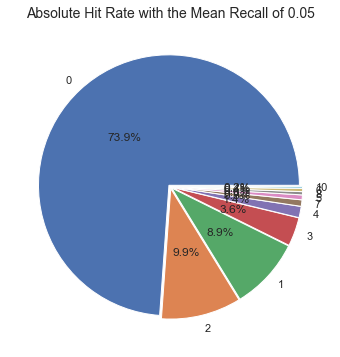

In [272]:
l, ax = plt.subplots(figsize=[10,6])
labels = pie['hit_rate']
plt.pie(x=pie['count'], autopct="%.1f%%",labels=labels,explode=[0.015]*len(pie['count']), pctdistance=0.5)
plt.title("Absolute Hit Rate with the Mean Recall of {:.2f}".format(np.mean(content_based_eval['recall'])), fontsize=14)

<h2 style="text-align:center;">Building a Collaboration Based Recommendation System using ALS from Implicit Library - </h1>

In [273]:
## installing the implicit package
!pip install implicit

In [274]:
## importing the relevant classes and functions
from scipy.sparse import csr_matrix, save_npz, load_npz, vstack, hstack, lil_matrix
import implicit
from implicit.evaluation import train_test_split, precision_at_k, mean_average_precision_at_k

In [275]:
user_item.tail()

,consumer_id,item_id,text_description
40705,9210530975708218054,8477804012624580461,"""Em 2020, as pessoas não irão usar aplicativos..."
40706,9210530975708218054,8526042588044002101,As Craig and I start our journey toward buildi...
40707,9210530975708218054,8856169137131817223,Para ser realmente inovador você não precisa n...
40708,9210530975708218054,8869347744613364434,"Serial, Parallel, Concurrent, CMS, G1, Young G..."
40709,9210530975708218054,9209886322932807692,"Recentemente, a equipe do Chrome anunciou que ..."


#### Converting consumer id and item id into categories as the Implicit ALS algo demands so

In [276]:
user_item['consumer_id'] = user_item['consumer_id'].astype("category")

In [277]:
user_item['item_id'] = user_item['item_id'].astype("category")

In [278]:
# creating the sparse user item matrix
alpha = 40
sparse_user_item = csr_matrix( ([alpha]*len(user_item['item_id']), (user_item['consumer_id'].cat.codes.copy(), user_item['item_id'].cat.codes.copy()) ))

In [279]:
#print(sparse_user_item)

In [280]:
sparse_item_user = sparse_user_item.T.tocsr()

In [281]:
#print(sparse_item_user)

In [282]:
# splitting into test and train
train_item_user, test_item_user = train_test_split(sparse_item_user, train_percentage=0.8)

train_user_item, test_user_item = train_test_split(sparse_user_item, train_percentage=0.8)

In [283]:
# building the collaborative filtering model

model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.001, iterations=1500, calculate_training_loss=True)

In [284]:
model.fit(train_item_user)

In [285]:
# creating a mapping between original user_id and the user_id given in sparse matrix
# will be used while making the recommendation system

user_id_mapping = dict(zip(user_item['consumer_id'].unique(),user_item['consumer_id'].cat.codes.copy().unique()))
item_id_mapping = dict(zip(user_item['item_id'].cat.codes.copy().unique(),user_item['item_id'].unique()))

In [286]:
# building the collaboration based recommender system

def recommend(user_id):
    
    mapped_user_id = user_id_mapping[user_id]
    
    recommended, _ =  zip(*model.recommend(mapped_user_id, sparse_user_item))
    
    recommended_articles = []
    
    for mapped_item_id in recommended:
        
        item_id = item_id_mapping[mapped_item_id]
        
        recommended_articles.append(platform_content[platform_content['item_id']==item_id]['title'].values[0])
        
    return recommended_articles

In [287]:
# testing the collaboration based recommender system

recommend(-9196668942822132778)

['Lava-louças Brastemp Ative! 8 Serviços Blf08abana 110v - R$ 800,00',
 'The Top 10 Most Common Mistakes That Node.js Developers Make',
 'How it feels to learn Javascript in 2016',
 'Cubr',
 "Brazil's Bank Itaú Joins R3 Blockchain Consortium - CoinDesk",
 'Citroën lança e-commerce de carros',
 'Banco desafia empreendedores e estudantes de tecnologia a buscarem inovação para processos | EXAME.com',
 'VMware Cloud™ on AWS - A Closer Look - frankdenneman.nl',
 "Don't document your code. Code your documentation.",
 'Terça de Dados #11 - Debate sobre a Regulamentação de TI']

In [288]:
## content based recommendations
news_recommendation_using_user_id(-9196668942822132778)

['Iniciando com o Docker: dicas práticas para começar a usar agora mesmo - Tableless',
 'Use Docker to build, test and push your Artifacts',
 'Itaú segue tendência das fintechs e se torna primeiro banco tradicional a permitir abertura de contas por app - Startupi',
 'Docker Swarm',
 "Docker Engine 1.11 with runC: Announcing the general availability of the industry's first OCI-compliant runtime",
 'Why You Should Stop Installing Your WebDev Environment Locally - Smashing Magazine',
 'Microsoft expands its support for Docker containers',
 'Automate Docker with the Remote API and Ruby',
 'Docker 1.12: Now with Built-in Orchestration!',
 'Iniciando com o Docker: Criando suas próprias imagens - Tableless']

In [289]:
## articles that the user had read based on which the above recommendations were made

user_item_verify[user_item_verify['consumer_id']==-9196668942822132778]['title'].unique()

array(['Itaú é pioneiro do blockchain',
       'Contêiner do Windows no Windows 10',
       'Docker - Build, Ship, and Run Any App, Anywhere',
       'Webinário gratuito "Como analisar um AWR Report"',
       'Itaú Unibanco fecha compra de ativos de varejo do Citi no Brasil',
       '15 minutos sobre Docker'], dtype=object)

<b>Based on the verification above, it seems that the recommendation system is working well - 

The Content Based Recommendation System is suggesting articles quite similar to the ones already read.<br>
The Collaboration Based Recommendation System is suggesting articles of similar theme.</b>

## Evaluating the ALS Model - 

#### Will use the metric Precision at K(k=10) to evaluate the model

In [290]:
p_at_10 = precision_at_k(model,train_item_user.T.tocsr(),test_item_user.T.tocsr(),K=10)

In [291]:
print("Precision at 10 comes out to be {:.2f}".format(p_at_10))

Precision at 10 comes out to be 0.14


### Now lets build the above ALS algo. on our own  - 

<h1 style="text-align:center;"> Building an ALS based Recommendation System <u><i>from Scratch</i></u> - </h1>

Lets first study a bit about ALS Algorithm - <br><br>

ALS involves Matrix factorization which assumes that:<br>
<ul><li>Each user can be described by k attributes or features. For example, feature 1 might be a number that says how much each user likes sci-fi movies.</li>
<li>Each item (movie) can be described by an analagous set of k attributes or features. To correspond to the above example, feature 1 for the movie might be a number that says how close the movie is to pure sci-fi.</li>
<li>If we multiply each feature of the user by the corresponding feature of the movie and add everything together, this will be a good approximation for the rating the user would give that movie.</li>
<br>
 
<b>The beauty is that we do not know what these features are. Nor do we know how many (k) features are relevant. We simply pick a number for k and learn the relevant values for all the features for all the users and items. How do we learn? By minimizing a loss function, of course!</b>

### Some Maths - 

We can turn our matrix factorization approximation of a k-attribute user into math by letting a user u take the form of a k-dimensional vector x_u. Similarly, an item i can be k-dimensional vector y_i. User u’s predicted rating for item i is just the dot product of their two vectors.

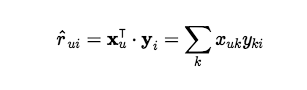

where r_ui hat represents our prediction for the true rating r_ui, and y_i (x⊺_u) is assumed to be a column (row) vector. These user and item vectors are often called latent vectors or low-dimensional embeddings in the literature. The k attributes are often called the latent factors. We will choose to minimize the square of the difference between all ratings in our dataset (S) and our predictions. This produces a loss function of the form

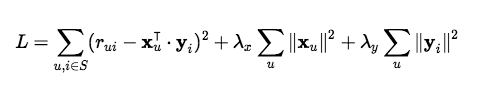

Note that we’ve added on two L2 regularization terms at the end to prevent overfitting of the user and item vectors. Our goal now is to minimize this loss function. Derivatives are an obvious tool for minimizing functions, we will be one of the derivative based method - <b>ALS Algo</b>

For ALS minimiztion, we hold one set of latent vectors constant. <br><br>For this example, we’ll pick the item vectors. We then take the derivative of the loss function with respect to the other set of vectors (the user vectors). We set the derivative equal to zero (we’re searching for a minimum) and solve for the non-constant vectors (the user vectors). <br><br>Now comes the alternating part: With these new, solved-for user vectors in hand, we hold them constant, instead, and take the derivative of the loss function with respect to the previously constant vectors (the item vectors). <br><br>
<b>We alternate back and forth and carry out this two-step dance until convergence.</b>

### ALS Derivation

### Step - 1
To explain things with math, let’s hold the item vectors (y_i) constant and take the derivative of the loss function with respect to the user vectors (x_u)

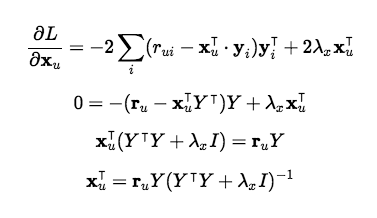

A couple things happen above: let us assume that we have n users and m items, so our ratings matrix is n×m. We introduce the symbol Y (with dimensioins m×k) to represent all item row vectors vertically stacked on each other. Also, the row vector r_u just represents users u’s row from the ratings matrix with all the ratings for all the items (so it has dimension 1×m). Lastly, I is just the identity matrix which has dimension k×k here.

### Step - 2
The derivation for the item vectors is quite similar - 

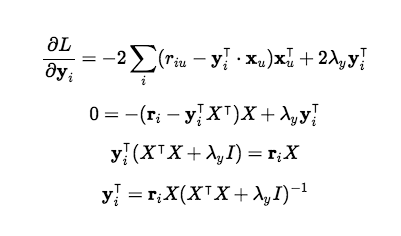

### Lets turn this into code - 

### All the articles are the ones that the user has either liked, commented, saved or followed. Hence the user seems to be interested in the topics. Hence I will mark the rating as 4 for all of these. 

In [292]:
user_item['rating'] = 4

In [293]:
user_item.tail()

,consumer_id,item_id,text_description,rating
40705,9210530975708218054,8477804012624580461,"""Em 2020, as pessoas não irão usar aplicativos...",4
40706,9210530975708218054,8526042588044002101,As Craig and I start our journey toward buildi...,4
40707,9210530975708218054,8856169137131817223,Para ser realmente inovador você não precisa n...,4
40708,9210530975708218054,8869347744613364434,"Serial, Parallel, Concurrent, CMS, G1, Young G...",4
40709,9210530975708218054,9209886322932807692,"Recentemente, a equipe do Chrome anunciou que ...",4


### Using only those users which have interacted with atleast 3 articles so that the train-test split is not empty

In [294]:
## Number of articles per user
df = user_item.groupby('consumer_id',as_index=False).count()

In [295]:
## users having interest in atleast 3 articles
atleast_3 = df[df['item_id']>=3]

In [296]:
## we will only deal with users who have shown interest in atleast 3 articles as we want to split the data into train and test
user_item = user_item[user_item['consumer_id'].isin(atleast_3['consumer_id'])]

Now I will be creating a mapping of consumer_ids and item_ids to positive integers so that they are easier to deal with

In [297]:
user_mapping = {}
item_mapping = {}

In [298]:
for idx,item_id in enumerate(list(user_item['item_id'].unique())):
    item_mapping[idx] = item_id

In [299]:
for idx,user_id in enumerate(list(user_item['consumer_id'].unique())):
    user_mapping[idx] = user_id

In [300]:
def return_key(dictionary,val):
    for key,value in dictionary.items():
        if value==val:
            return int(key)

In [301]:
user_item['user_id'] = user_item['consumer_id'].apply(lambda x:return_key(user_mapping,x))

In [302]:
user_item['user_id'] = user_item['user_id'].astype('int')

In [303]:
user_item['article_id'] = user_item['item_id'].apply(lambda x:return_key(item_mapping,x))

In [304]:
user_article = user_item[['user_id','article_id','rating']].copy(deep=True)

In [305]:
user_article.tail()

,user_id,article_id,rating
40705,1385,470,4
40706,1385,908,4
40707,1385,1095,4
40708,1385,972,4
40709,1385,1724,4


### Creating a Ratings Matrix

In [306]:
n_users = user_article['user_id'].unique().shape[0]

n_items = user_article['article_id'].unique().shape[0]

ratings = np.zeros((n_users, n_items))

In [307]:
for row in user_article.itertuples():
    ratings[row[1], row[2]] = row[3]

In [308]:
ratings.shape
# 1386 users and 2105 articles

(1386, 2105)

In [309]:
print(str(n_users) + ' users')
print(str(n_items) + ' items')
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
sparsity = 100 - sparsity
print('Sparsity: {:4.2f}%'.format(sparsity))

1386 users
2105 items
Sparsity: 98.70%


As expected, the matrix is highly sparsed

In [310]:
## create a dictionary to store the number of articles interested in by a user
user_article_read={}

In [311]:
df = user_article.groupby('user_id',as_index=False).count()

In [312]:
for row in df.itertuples():
    user_article_read[row[1]] = row[2]

Splitting the dataset into train and test, such that test dataset have 30% or 10(whichever less) articles shown interest by a user

In [313]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        print(user)
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=round(0.3*user_article_read[user]), 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [314]:
train, test = train_test_split(ratings)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [315]:
# Training articles for user 0
train[4].nonzero()

(array([61, 63, 64, 66], dtype=int64),)

In [316]:
# Test articles for user 0
test[4].nonzero()

(array([62, 65], dtype=int64),)

In [317]:
from numpy.linalg import solve

### Implementing the Mathematical Formulaes discussed - 

Defining a class with the various methods to execute the parts of the ALS algo

In [318]:
class ALS_Algo():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [319]:
## defining the get_mse function used in the above function
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [320]:
## function to recommend collaboration based articles using user_id

def recommendations_ALS_scratch(model,user_id,num_recommendations):
    
    # getting user id for ALS Model
    user = return_key(user_mapping,user_id)
    
    recommendations = []
    
    output_articles = []
    
    # articles that had already been read by a user
    already_read_articles = list(train[user,:].nonzero()[0])
      
    for item,article in item_mapping.items():
        
        # so that already interacted articles are not recommended again
        if item not in already_read_articles:
        
            recommendations.append((platform_content[platform_content['item_id']==article]['title'].values[0],model.predict(user,item)))
    
    # sorting based on the score
    recommendations = sorted(recommendations,key=lambda w:w[1], reverse=True)
    
    for suggested_article,score in recommendations:
        
        output_articles.append(suggested_article)
    
    return output_articles[0:num_recommendations]

In [321]:
## Initiating the ALS object
MF_ALS = ALS_Algo(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)

# iterations to train and test mse
iter_array = [1, 2, 5, 10, 25, 50, 100,500]

# calculating mse
MF_ALS.calculate_learning_curve(iter_array, test)

In [322]:
# using the model to make recommendations
recommendations_ALS_scratch(MF_ALS,-8763398617720485024,5)

["Things you probably didn't know you could do with Chrome's Developer Console",
 'When to make a Git Commit',
 'DBA BRASIL no INTEROPMIX 2016',
 'The technology behind preview photos',
 'Advanced Android Espresso']

In [323]:
# functions to plot the mse

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

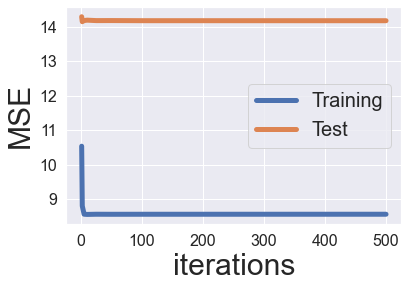

In [324]:
## plotting the mse

plot_learning_curve(iter_array, MF_ALS)

In [325]:
# Model with an increase Regularisation Value
MF_ALS = ALS_Algo(train, n_factors=5,user_reg=0.01, item_reg=0.01)

# Calculating MSE
iter_array = [1, 2, 5, 10, 25, 50, 100,500]
MF_ALS.calculate_learning_curve(iter_array, test)

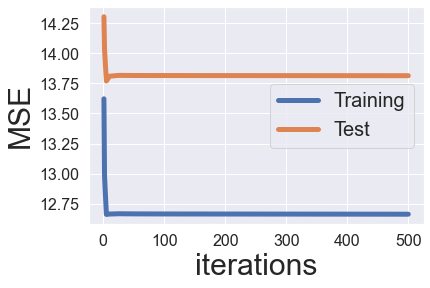

In [326]:
plot_learning_curve(iter_array, MF_ALS)

### Hyper-Parameter Tuning

In [ ]:
latent_factors = [5,10,20,30,40]
regularizations = [0.001,0.01,0.1]
regularizations.sort()
iter_array = [1000]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print ('Factors: {}'.format(fact))
    for reg in regularizations:
        print ('Regularization: {}'.format(reg))
        MF_ALS = ALS_Algo(train, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print ('New optimal hyperparameters')
            print (pd.Series(best_params))

Factors: 5
Regularization: 0.001


In [ ]:
best_params

In [ ]:
best_model = ALS_Algo(train, n_factors=10,user_reg=0.001, item_reg=0.001)

iter_array = [1,2,5,10,50,100,500,1000]
best_model.calculate_learning_curve(iter_array, test)
plot_learning_curve(iter_array, best_model)

In [ ]:
best_als_model = best_params['model']

In [ ]:
## recommendations using the best model
recommendations_ALS_scratch(best_als_model,1754215888246437356,5)

### Hybrid Recommendation System

To make a Hybrid model, what we can do is - 

1. Include the articles which are common to both content and collaboration based recommendation system
2. <br>A. Include 2 articles from Content with 1 article from Collaboration and so on. So the weightage given to content will be 66% while 33% to collaboration but they will be placed such that after every 2 recommendation from Content we get one recommendation from collaboration.<br><br>
    B. Include 1 article from Collaboration with 1 article from Content and so on. So the weightage given to content will be 50% to each.<br><br>
    C. Include 2 articles from Collaboration with 1 article from Content and so on. So the weightage given to Collaboration will be 66% while 33% to content but they will be placed such that after every 2 recommendation from Collaboration we get one recommendation from content.
    
Lets see which one gives the best results!

In [ ]:
def hybrid_model_recommendations(user_id,hybrid_method):
    
    content_based = news_recommendation_using_user_id(user_id)
    
    collaboration_based = recommendations_ALS_scratch(best_als_model,user_id,5)
    
    common = set(content_based).intersection(set(collaboration_based))
    
    for article in common:
        
        content_based.remove(article)
        
        collaboration_based.remove(article)
    
    output = []
    
    output_dict = {}
    
    output+=list(common)
    
    if hybrid_method == 1:
        
        while len(content_based)+len(collaboration_based)>0:
                
                if len(content_based)>0:
                    output.append(content_based.pop(0) )
                if len(content_based)>0:
                    output.append(content_based.pop(0))
                if len(collaboration_based)>0:
                    output.append(collaboration_based.pop(0))
                    
        return output
            
    if hybrid_method == 2:
        
        while len(content_based)+len(collaboration_based)>0:
                
                if len(collaboration_based)>0:
                    output.append(collaboration_based.pop(0))
                if len(content_based)>0:
                    output.append(content_based.pop(0) )
                    
        return output
    
    if hybrid_method == 3:
        
        while len(content_based)+len(collaboration_based)>0:
                
                if len(collaboration_based)>0:
                    output.append(collaboration_based.pop(0) )
                if len(collaboration_based)>0:
                    output.append(collaboration_based.pop(0))
                if len(content_based)>0:
                    output.append(content_based.pop(0))
                    
        return output
                    
    if hybrid_method == "All":
        
        output_1 = hybrid_model_recommendations(user_id,1)
        output_2 = hybrid_model_recommendations(user_id,2)
        output_3 = hybrid_model_recommendations(user_id,3)
        
        output_dict["method_1"] = output_1
        output_dict["method_2"] = output_2
        output_dict["method_3"] = output_3
        
        return output_dict

In [ ]:
hybrid_model_recommendations(-9172914609055320039,1)

<h2 style="text-align:center;"> Evaluating the Hybrid Model - </h2>

<h3 style="text-align:center;">Evaluation Technique -</h3> 

I will be using <b>Precision @ K</b>, where K=10, to evaluate the model. I am not concerned about the order in which the recommendations are made as I believe that it is with movies that the order matters much. The reason is that movies are 2-3 hours long and it takes time to judge if you actually like one or not. With articles, you can skim through them in a few minutes and move onto the next!

Hence for me, I want to make sure that the model makes the maximum number of relevant recommendations without paying much heed to the order of recommendations!

<b> Approach </b> - 
<br><br>
We have divided the data set in training and test data set. We take users from the training data and the model predicts 10 articles based on the articles present in the training data set for that user. <br><br>Precision at 10 = (Number of articles recommended that are present in the test dataset for that user)/10

In [ ]:
# Number of users
test.shape[0]

In [ ]:
## defined the function for content based recommendations given the list of articles read by a user
# precision is the number of recommendations as this will be used to calculate precision at K

def content_based_using_list_articles(article_id_list,precision):
    
    article_dictionary = {}
    
    item_ids = article_id_list
    
    for item in item_ids:
        news = item_df.loc[item_df.item_id==item] # get the movie row
        keywords = process_sentence(news['text_description'].values[0]) #get the keywords as a Series
        
        query_doc = keywords #set the query_doc to the list of keywords
    
        query_doc_bow = dictionary.doc2bow(query_doc) # get a bag of words from the query_doc
        query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
        # of the article ID and it's tf-idf value for the movie

        similarity_array = sims[query_doc_tfidf] 

        similarity_series = pd.Series(similarity_array.tolist(), index=item_df.item_id.values) #Convert to a Series
        top_hits = similarity_series.sort_values(ascending=False)[1:11]
        
        
        for (news_id,score) in zip(top_hits.index,top_hits):
            if news_id in article_dictionary:
                article_dictionary[news_id]+=score
            else:
                article_dictionary[news_id] = score
        
    sorted_items = sorted(article_dictionary.items(), key = 
             lambda kv:(kv[1], kv[0]),reverse=True)
    
    top_10_recommendations = []

        
    for key,value in sorted_items:
        if key not in item_ids and len(top_10_recommendations)<precision:
            top_10_recommendations.append((key,value))
        
    output = []
        
    # Print the top matching articles
    for item_id,score in top_10_recommendations:
        
        output.append(platform_content[platform_content['item_id']==item_id]['title'].values[0])
    
    return output
    

In [ ]:
def evaluate_hyrbrid(hybrid_method=1,precision=10):
    
    evaluation_metrics = []
    
    for user in range(test.shape[0]):
        
        article_ids = []
        
        training_article_names = []
        
        print("======== user {} out of {} ==============".format(user,test.shape[0]))
        
        counter = 0
        
        test_articles = []
        
        user_id = user_mapping[user]
        
        articles_in_train = list(train[user,:].nonzero()[0])
        
        for article in articles_in_train:
                
                article_ids.append(item_mapping[article])
                
        for article in article_ids:
            
            training_article_names.append(platform_content[platform_content['item_id']==article]['title'].values[0])
        
        # getting content based recommendations using the given set of article ids in the training set
        content_based = content_based_using_list_articles(article_ids,precision)
        
        # getting collaboration based recommmendations using the als model trained before
        collaboration_based = recommendations_ALS_scratch(best_als_model,user_mapping[user],precision)
        
        # articles in test dataset
        articles_in_test = list(test[user,:].nonzero()[0])
        
        for article in articles_in_test:
                
                test_articles.append(platform_content[platform_content['item_id']==item_mapping[article]]['title'].values[0])
        
        # common articles recommended by both training and testing algorithm
        common = set(content_based).intersection(set(collaboration_based))
        
        for article in common:

            content_based.remove(article)

            collaboration_based.remove(article)

        output = []

        output+=list(common)
        
        # For every 2 content based recommendations we have 1 collaboration based recommendation
        if hybrid_method == 1:

            while len(content_based)+len(collaboration_based)>0:

                    if len(content_based)>0:
                        output.append(content_based.pop(0) )
                    if len(content_based)>0:
                        output.append(content_based.pop(0))
                    if len(collaboration_based)>0:
                        output.append(collaboration_based.pop(0))
            
            # output has the list of recommendations
            for article in output[:precision]:
                # if recommended article is there in the test dataset articles, we increase the counter by 1
                if article in test_articles:
                    counter+=1
            
            # Precision at k
            evaluation_metrics.append((counter/precision))
            
            print(counter)

            
        # equal weightage to content and collaboration based recommendations
        if hybrid_method == 2:

            while len(content_based)+len(collaboration_based)>0:

                    if len(collaboration_based)>0:
                        output.append(collaboration_based.pop(0))
                    if len(content_based)>0:
                        output.append(content_based.pop(0) )

            for article in output[:precision]:
                if article in test_articles:
                    counter+=1
            
            
            evaluation_metrics.append((counter/precision))
            
            print(counter)
        
        # for every 2 collaboration based recommendations we have 1 content based recommendation
        if hybrid_method == 3:

            while len(content_based)+len(collaboration_based)>0:

                    if len(collaboration_based)>0:
                        output.append(collaboration_based.pop(0) )
                    if len(collaboration_based)>0:
                        output.append(collaboration_based.pop(0))
                    if len(content_based)>0:
                        output.append(content_based.pop(0))

            for article in output[:precision]:
                if article in test_articles:
                    counter+=1
            
            
            evaluation_metrics.append((counter/precision))
            
            print(counter)
        
        ## for every 3 content based recommendations, we have 1 collaboration based recommendation
        ## for a Precision@10 that amounts to 80% weightage to content based recommendations
        if hybrid_method == "80_content":

            while len(content_based)+len(collaboration_based)>0:

                    if len(content_based)>0:
                        output.append(content_based.pop(0) )
                    if len(content_based)>0:
                        output.append(content_based.pop(0))
                    if len(content_based)>0:
                        output.append(content_based.pop(0))
                    if len(collaboration_based)>0:
                        output.append(collaboration_based.pop(0))

            for article in output[:precision]:
                if article in test_articles:
                    counter+=1
            
            
            evaluation_metrics.append((counter/precision))
            
            print(counter)
        
        ## for every 3 collaboration based recommendations, we have 1 content based recommendation
        ## for a Precision@10 that amounts to 80% weightage to collaboration based recommendations
        if hybrid_method == "80_collab":

            while len(content_based)+len(collaboration_based)>0:

                    if len(collaboration_based)>0:
                        output.append(collaboration_based.pop(0) )
                    if len(collaboration_based)>0:
                        output.append(collaboration_based.pop(0))
                    if len(collaboration_based)>0:
                        output.append(collaboration_based.pop(0))
                    if len(content_based)>0:
                        output.append(content_based.pop(0))

            for article in output[:precision]:
                if article in test_articles:
                    counter+=1
            
            
            evaluation_metrics.append((counter/precision))
            
            print(counter)

    
        if user%10 == 0:

            print("=============dumping into Pickle==========================")
            
            with open('precision_hybrid_'+str(hybrid_method)+'_precision_'+str(precision)+'.pickle', 'wb') as handle:
                pickle.dump(evaluation_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
            print("Precision @ {} = {}".format(precision,np.mean(evaluation_metrics)))

    print("Precision @ {} = {}".format(precision,np.mean(evaluation_metrics)))
    
    return evaluation_metrics

In [ ]:
import os.path

In [ ]:
## checking precision @ 10 for the first method
if not os.path.isfile('precision_hybrid_1_precision_10.pickle'):
    precision_at_10_list = evaluate_hyrbrid(hybrid_method=1,precision=10)
else:
    with open('precision_hybrid_1_precision_10.pickle', 'rb') as handle:
        precision_at_10_list = pickle.load(handle)

In [ ]:
print("Precision @ 10 for first Method - {}".format(np.mean(precision_at_10_list)))

In [ ]:
if not os.path.isfile('precision_hybrid_2_precision_10.pickle'):
    precision_at_10_list_method_2 = evaluate_hyrbrid(hybrid_method=2,precision=10)
else:
    with open('precision_hybrid_2_precision_10.pickle', 'rb') as handle:
        precision_at_10_list_method_2 = pickle.load(handle)

In [ ]:
print("Precision @10 for Second Method - ",np.mean(precision_at_10_list_method_2))

In [ ]:
if not os.path.isfile('precision_hybrid_3_precision_10.pickle'):
    precision_at_10_list_method_3 = evaluate_hyrbrid(hybrid_method=3,precision=10)
else:
    with open('precision_hybrid_3_precision_10.pickle', 'rb') as handle:
        precision_at_10_list_method_3 = pickle.load(handle)

In [ ]:
print("Precision @10 for Third Method - ",np.mean(precision_at_10_list_method_3))

In [ ]:
if not os.path.isfile('precision_hybrid_80_collab_precision_10.pickle'):
    precision_at_10_list_final_v2 = evaluate_hyrbrid(hybrid_method="80_collab",precision=10)
else:
    with open('precision_hybrid_80_collab_precision_10.pickle', 'rb') as handle:
        precision_at_10_list_final_v2 = pickle.load(handle)

In [ ]:
print("Precision @10 for 80% weightage to Collaboration based model - ",np.mean(precision_at_10_list_final_v2))

In [ ]:
if not os.path.isfile('precision_hybrid_80_content_precision_10.pickle'):
    precision_at_10_list_final = evaluate_hyrbrid(hybrid_method="80_content",precision=10)
else:
    with open('precision_hybrid_80_content_precision_10.pickle', 'rb') as handle:
        precision_at_10_list_final = pickle.load(handle)

In [ ]:
print("Precision @10 for 80% weightage to content based model - ",np.mean(precision_at_10_list_final))

<h1 style="text-align:center;"> Final Observations </h1>

==============================================================================
<h3 style="text-align:center;">Precision @ 10 for various cases - </h3>

<br><br>Case 1: 80% Content Based & 20% Collaboration Based = 0.042

Case 2: 66% Content Based & 33% Collaboration Based = 0.046

Case 3: 50% Content Based & 50% Collaboration Based = 0.051

Case 4: 33% Content Based and 66% Collaboration Based = 0.053

<b>Case 5: 20% Content Based and 80% Collaboration Based = 0.056</b><br>

=================================================================================

### Making the User-Item Profile

#### This can be used to make recommendations based on user-user similarity.
###### Did this in this assignment as it was part of an evaluation rubric

In [ ]:
user_item['count'] = 1

In [ ]:
user_item_profile = user_item.pivot_table(index='consumer_id',columns=['item_id'],values='count')

In [ ]:
user_item_profile.head()

### Calculating user similarity matrix

##### Used cosine similarity as the measure of similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
user_item_profile.fillna(0,inplace=True)

In [ ]:
# user similarity matrix
user_sim = cosine_similarity(user_item_profile)

In [ ]:
# this is used to get to the top n elements of a list
import heapq

In [ ]:
def get_key(val):
    for key, value in user_id_mapping.items():
         if val == value:
                return key

In [ ]:
def get_similar_users(user_id,n_users):
    
    sim_vector_user = user_sim[user_id_mapping[user_id]]
    
    users = heapq.nlargest(n_users+1, range(len(sim_vector_user)), key=sim_vector_user.__getitem__)[1:]
    
    similar_users = []
    
    articles_by_user = set(user_item_verify[user_item_verify['consumer_id']==user_id]['title'].unique())
    
    for sim_user in users:
        
        articles_by_sim_user = set(user_item_verify[user_item_verify['consumer_id']==get_key(sim_user)]['title'].unique())
        
        common_articles = len(articles_by_user.intersection(articles_by_sim_user))
        
        similar_users.append((get_key(sim_user),common_articles))
    
    print("Similar Users to {} - ".format(user_id))
    for costumer,common_count in similar_users:
        
        print("User '{}' with {} common articles read".format(costumer,common_count))

In [ ]:
get_similar_users(1202287501580555390,5)

### Item Similarity matrix has already been created using GenSim Library above while making the context based recommendation system